In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium
from folium.plugins import HeatMap
import re

# Load Datasets

In [160]:
speed = pd.read_csv('/Users/annaywj/Downloads/SOC_-_Local_Roads__Speed_and_Volume_20250318.csv')
crashes = pd.read_csv('/Users/annaywj/Desktop/SDSU/BDA600/Capstone/TIMS_SD_Crashes2013-2024.csv')

In [161]:
speed.head()

,osm_id,Street Name,Highway,Lanes,Speed Limit MPH,Length,Direction,PeakPeriod,Speed 2022 MPH,Speed 2021 MPH,1 year Speed % change,2022 AADT Range,2021 AADT Range,1 year AADT % change,geometry
0,153343706,"Orange Avenue, CA 75",primary,2,40,43.61,S,AM,18.0,18.8,-4.0,"10,000-19,999","10,000-19,999",13.5,LINESTRING (-117.178938176757 32.6836120192024...
1,153343706,"Orange Avenue, CA 75",primary,2,40,43.61,S,PM,16.9,17.3,-2.5,"10,000-19,999","10,000-19,999",13.5,LINESTRING (-117.178938176757 32.6836120192024...
2,161508068,Nimitz Boulevard,primary,-1,40,41.71,SE,AM,16.2,16.6,-2.1,"5,000-9,999","5,000-9,999",-2.6,LINESTRING (-117.221695942172 32.7260512722891...
3,161508068,Nimitz Boulevard,primary,-1,40,41.71,SE,PM,16.5,19.7,-16.4,"5,000-9,999","5,000-9,999",-2.6,LINESTRING (-117.221695942172 32.7260512722891...
4,186470511,Pacific Highway,primary,2,50,94.44,SE,AM,36.5,NaN,NaN,"5,000-9,999",NaN,NaN,LINESTRING (-117.195756931508 32.7457416671308...


In [162]:
crashes.head()

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,COUNT_MC_KILLED,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y
0,5639604,2013,2015-01-14,3711,2013-02-01,1816,6000,NaN,5,5,...,0,0,-,-,NaN,NaN,SAN DIEGO,SAN DIEGO,-117.093777,32.694394
1,5639619,2013,2013-03-11,9680,2013-01-19,410,019936,NaN,6,3,...,0,0,-,-,32.85306,-116.86512,SAN DIEGO,UNINCORPORATED,-116.864564,32.853113
2,5639726,2013,2015-01-14,3711,2013-02-06,1940,3792,3711,3,5,...,0,1,-,-,NaN,NaN,SAN DIEGO,SAN DIEGO,-117.079670,32.735391
3,5639817,2013,2015-01-15,3711,2013-02-18,1937,4243,NaN,1,5,...,0,0,-,-,NaN,NaN,SAN DIEGO,SAN DIEGO,-117.122654,32.917255
4,5639818,2013,2013-03-14,3711,2013-02-01,1143,3661,SANDI,5,5,...,0,0,-,-,NaN,NaN,SAN DIEGO,SAN DIEGO,-117.159290,32.990074


# Preprocessing

In [163]:
speed.columns = speed.columns.str.strip().str.replace(" ", "_")
crashes.columns = crashes.columns.str.strip().str.replace(" ", "_")

In [164]:
speed_relevant = speed[['Street_Name', 'Lanes', 'Speed_Limit_MPH', 'Speed_2022_MPH',
                        '2022_AADT_Range', '1_year_Speed_%_change', '1_year_AADT_%_change']].copy()
crash_relevant = crashes[['PRIMARY_RD', 'COLLISION_SEVERITY', 'ROAD_SURFACE', 'ROAD_COND_1']].copy()

In [165]:
speed_relevant['Street_Name'] = speed_relevant['Street_Name'].astype(str).str.upper().str.strip()
crash_relevant['PRIMARY_RD'] = crash_relevant['PRIMARY_RD'].astype(str).str.upper().str.strip()

In [166]:
crash_summary = crash_relevant.groupby('PRIMARY_RD').agg({
    'COLLISION_SEVERITY': ['count', 'mean'],
    'ROAD_SURFACE': lambda x: x.value_counts().idxmax(),
    'ROAD_COND_1': lambda x: x.value_counts().idxmax()
}).reset_index()

In [167]:
crash_summary.columns = ['ROAD', 'TOTAL_CRASHES', 'AVG_SEVERITY', 'COMMON_SURFACE', 'COMMON_CONDITION']

In [168]:
merged_data = pd.merge(speed_relevant, crash_summary, how='inner', left_on='Street_Name', right_on='ROAD')

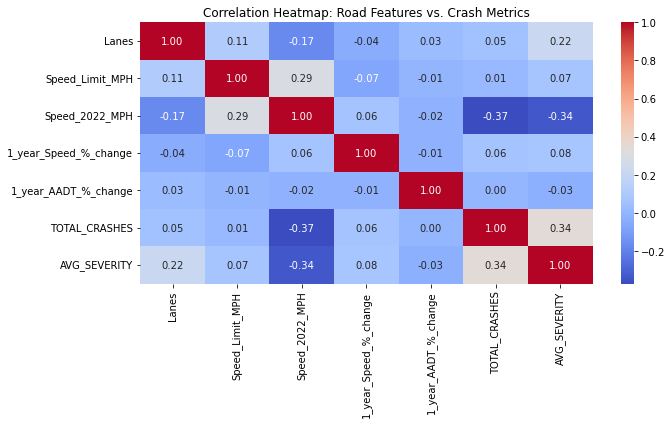

In [169]:
plt.figure(figsize=(10, 6))
corr_matrix = merged_data[['Lanes', 'Speed_Limit_MPH', 'Speed_2022_MPH',
                           '1_year_Speed_%_change', '1_year_AADT_%_change',
                           'TOTAL_CRASHES', 'AVG_SEVERITY']].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Road Features vs. Crash Metrics')
plt.tight_layout()
plt.show()

# Analysis

In [170]:
lanes_analysis = merged_data.groupby('Lanes').agg({
    'TOTAL_CRASHES': 'sum',
    'AVG_SEVERITY': 'mean',
    'Street_Name': 'count'
}).rename(columns={'Street_Name': 'ROAD_COUNT'}).reset_index()

#### Crashes per Lane Count

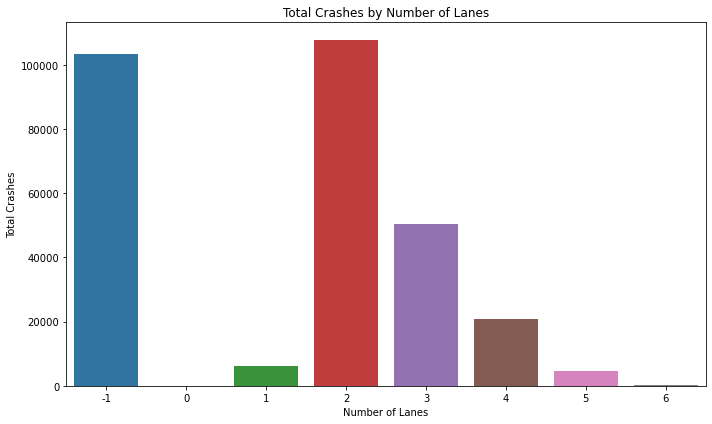

In [171]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Lanes', y='TOTAL_CRASHES', data=lanes_analysis)
plt.title('Total Crashes by Number of Lanes')
plt.xlabel('Number of Lanes')
plt.ylabel('Total Crashes')
plt.tight_layout()
plt.show()

#### Average Crash Severity per Lane Count

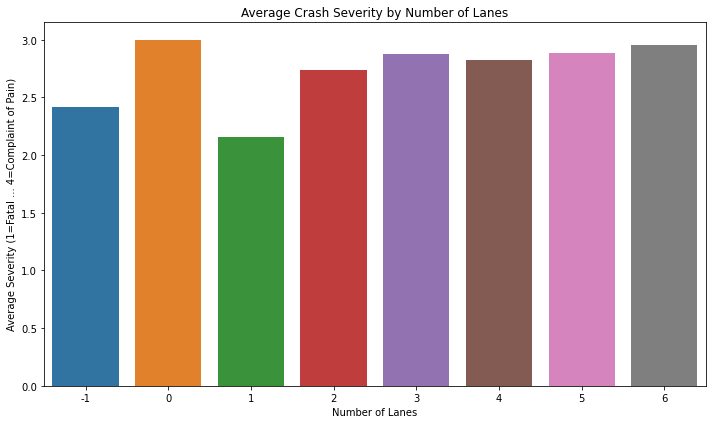

In [172]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Lanes', y='AVG_SEVERITY', data=lanes_analysis)
plt.title('Average Crash Severity by Number of Lanes')
plt.xlabel('Number of Lanes')
plt.ylabel('Average Severity (1=Fatal ... 4=Complaint of Pain)')
plt.tight_layout()
plt.show()

#### Severity by Road Surface (Dry vs Wet)

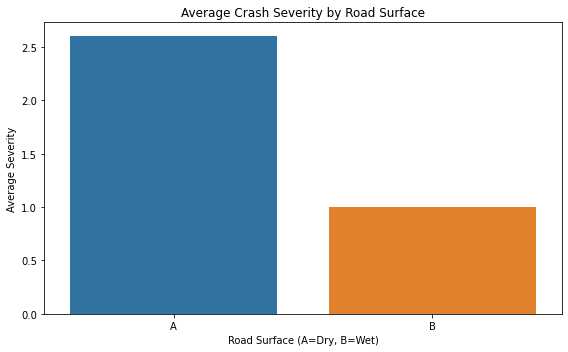

In [173]:
surface_severity = merged_data.groupby('COMMON_SURFACE').agg({
    'TOTAL_CRASHES': 'sum',
    'AVG_SEVERITY': 'mean'
}).reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='COMMON_SURFACE', y='AVG_SEVERITY', data=surface_severity)
plt.title('Average Crash Severity by Road Surface')
plt.xlabel('Road Surface (A=Dry, B=Wet)')
plt.ylabel('Average Severity')
plt.tight_layout()
plt.show()

#### Crash Rate per Road (normalized by lane count)

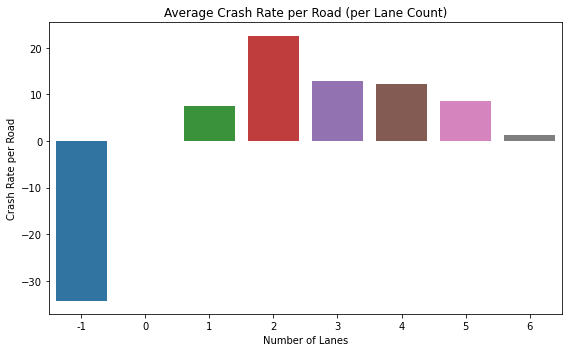

In [174]:
merged_data['CRASH_RATE_PER_LANE'] = merged_data['TOTAL_CRASHES'] / merged_data['Lanes']
crash_rate_by_lanes = merged_data.groupby('Lanes').agg({
    'CRASH_RATE_PER_LANE': 'mean'
}).reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='Lanes', y='CRASH_RATE_PER_LANE', data=crash_rate_by_lanes)
plt.title('Average Crash Rate per Road (per Lane Count)')
plt.xlabel('Number of Lanes')
plt.ylabel('Crash Rate per Road')
plt.tight_layout()
plt.show()

#### AADT vs. Crashes across Lanes

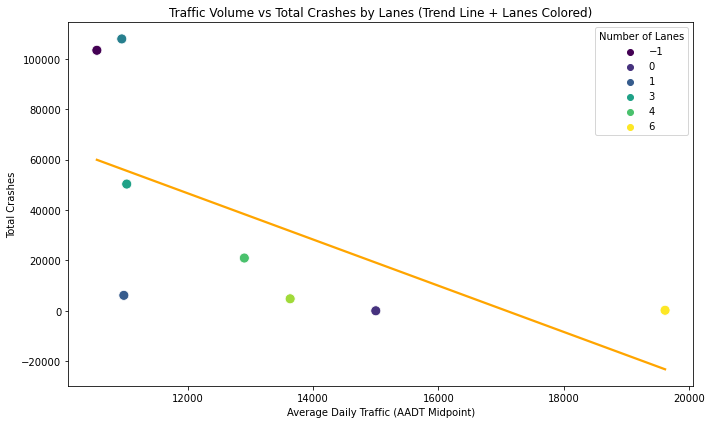

In [175]:
# Clean AADT values and convert to midpoint for analysis
def extract_mid_aadt_range(range_str):
    if isinstance(range_str, str) and '-' in range_str:
        low, high = range_str.replace(',', '').split('-')
        return (int(low) + int(high)) / 2
    return None

merged_data['AADT_MIDPOINT'] = merged_data['2022_AADT_Range'].apply(extract_mid_aadt_range)

aadt_lane_crash = merged_data.groupby('Lanes').agg({
    'AADT_MIDPOINT': 'mean',
    'TOTAL_CRASHES': 'sum'
}).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='AADT_MIDPOINT', y='TOTAL_CRASHES', hue='Lanes', data=aadt_lane_crash, palette='viridis', s=100)
sns.regplot(x='AADT_MIDPOINT', y='TOTAL_CRASHES', data=aadt_lane_crash, scatter=False, color='orange', ci=None)
plt.title('Traffic Volume vs Total Crashes by Lanes (Trend Line + Lanes Colored)')
plt.xlabel('Average Daily Traffic (AADT Midpoint)')
plt.ylabel('Total Crashes')
plt.legend(title='Number of Lanes')
plt.tight_layout()
plt.show()

#### Heatmap of Lanes vs. Speed vs. Severity

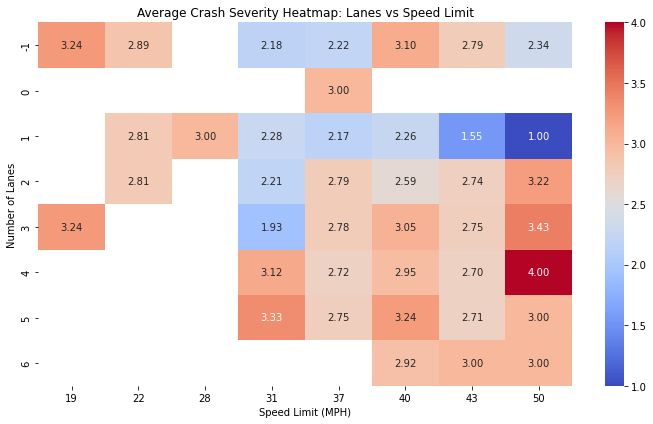

In [176]:
heatmap_data = merged_data.pivot_table(values='AVG_SEVERITY', index='Lanes', columns='Speed_Limit_MPH')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Average Crash Severity Heatmap: Lanes vs Speed Limit')
plt.xlabel('Speed Limit (MPH)')
plt.ylabel('Number of Lanes')
plt.tight_layout()
plt.show()

#### Condition Type Breakdown: Most Common Crash Conditions

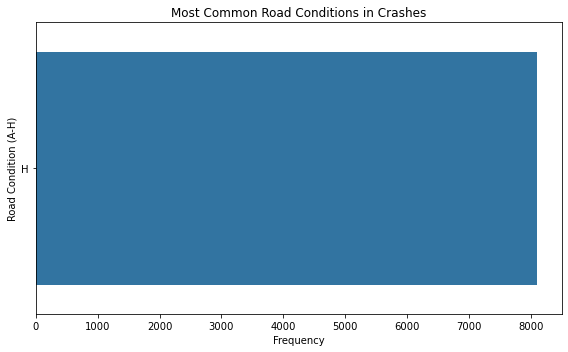

In [177]:
condition_breakdown = merged_data['COMMON_CONDITION'].value_counts().reset_index()
condition_breakdown.columns = ['Road Condition', 'Frequency']

plt.figure(figsize=(8, 5))
sns.barplot(y='Road Condition', x='Frequency', data=condition_breakdown)
plt.title('Most Common Road Conditions in Crashes')
plt.xlabel('Frequency')
plt.ylabel('Road Condition (A-H)')
plt.tight_layout()
plt.show()

#### Crash Severity Regression (scikit-learn)

In [178]:
model_data = merged_data[['Lanes', 'Speed_Limit_MPH', 'Speed_2022_MPH', 'AVG_SEVERITY', 'TOTAL_CRASHES']].dropna()

X = model_data[['Lanes', 'Speed_Limit_MPH', 'Speed_2022_MPH']]
y = model_data['AVG_SEVERITY']

reg_model = LinearRegression()
reg_model.fit(X, y)

y_pred = reg_model.predict(X)
r_squared = reg_model.score(X, y)

print("Crash Severity Regression Results:")
print("Intercept:", reg_model.intercept_)
print("R-squared:", r_squared)
print("\nCoefficients:")
for feature, coef in zip(X.columns, reg_model.coef_):
    print(f"{feature}: {coef:.4f}")

Crash Severity Regression Results:
Intercept: 2.0004971429737735
R-squared: 0.15759261359345655

Coefficients:
Lanes: 0.0585
Speed_Limit_MPH: 0.0383
Speed_2022_MPH: -0.0330


#### Road Risk Clustering (KMeans)

/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


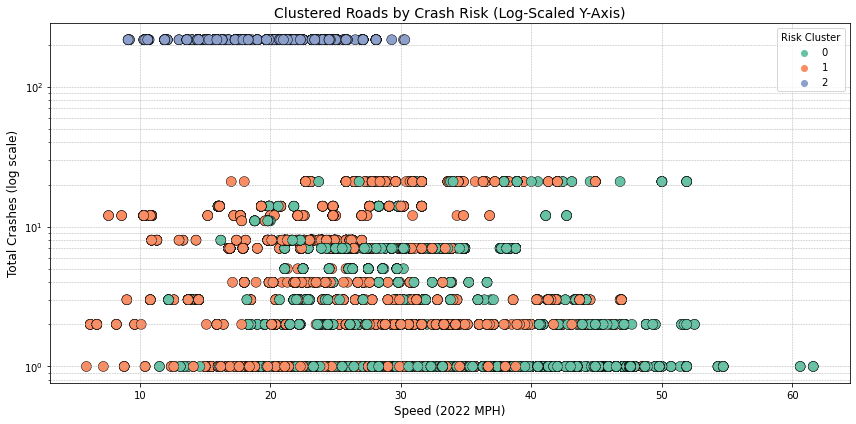

In [179]:
cluster_data = model_data[['Lanes', 'Speed_Limit_MPH', 'Speed_2022_MPH', 'TOTAL_CRASHES']].dropna()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_data)

kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(scaled_features)

model_data = model_data.loc[cluster_data.index] 
model_data['RISK_CLUSTER'] = clusters

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=model_data,
    x='Speed_2022_MPH',
    y='TOTAL_CRASHES',
    hue='RISK_CLUSTER',
    palette='Set2',
    s=100,
    edgecolor='black',
    linewidth=0.5
)

plt.yscale('log')
plt.title('Clustered Roads by Crash Risk (Log-Scaled Y-Axis)', fontsize=14)
plt.xlabel('Speed (2022 MPH)', fontsize=12)
plt.ylabel('Total Crashes (log scale)', fontsize=12)
plt.legend(title='Risk Cluster')
plt.tight_layout()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

In [180]:
# Reload
crashes = pd.read_csv('/Users/annaywj/Desktop/SDSU/BDA600/Capstone/TIMS_SD_Crashes2013-2024.csv')
soc = pd.read_csv('/Users/annaywj/Downloads/SOC_-_Local_Roads__Speed_and_Volume_20250318.csv')

crashes.columns = crashes.columns.str.strip().str.replace(" ", "_")
soc.columns = soc.columns.str.strip().str.replace(" ", "_")

In [181]:
# Extract LATITUDE and LONGITUDE
def extract_coords(geom):
    match = re.match(r"POINT\s*\(\s*(-?\d+\.\d+)\s+(-?\d+\.\d+)\s*\)", str(geom))
    if match:
        lon, lat = map(float, match.groups())
        return pd.Series({'LONGITUDE': lon, 'LATITUDE': lat})
    return pd.Series({'LONGITUDE': None, 'LATITUDE': None})

soc_coords = soc['geometry'].apply(extract_coords)
soc = pd.concat([soc, soc_coords], axis=1)
soc = soc.dropna(subset=['LATITUDE', 'LONGITUDE'])


In [182]:
crashes = crashes[crashes['LATITUDE'].notna() & crashes['LONGITUDE'].notna()]
crashes['LONGITUDE'] = -abs(crashes['LONGITUDE']) 
map_center = [crashes['LATITUDE'].mean(), crashes['LONGITUDE'].mean()]
severity_map = folium.Map(location=map_center, zoom_start=11)

In [183]:
heatmap_map = folium.Map(location=map_center, zoom_start=11)
heat_data = [[row['LATITUDE'], row['LONGITUDE']] for _, row in crashes.iterrows()]
HeatMap(heat_data).add_to(heatmap_map)

In [184]:
map_combo = folium.Map(location=map_center, zoom_start=11)

# Crash markers
def get_color(sev):
    return {
        1: 'red',
        2: 'orange',
        3: 'yellow',
        4: 'blue'
    }.get(sev, 'gray')

for _, row in crashes.head(500).iterrows():  # Limit for performance
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=4,
        popup=f"Severity: {row['COLLISION_SEVERITY']}",
        color=get_color(row['COLLISION_SEVERITY']),
        fill=True,
        fill_opacity=0.6
    ).add_to(map_combo)

# SOC points (e.g., speed data)
for _, row in soc.head(300).iterrows():  # Limit for performance
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=3,
        popup=f"Speed: {row.get('Speed_2022_MPH', 'N/A')} MPH",
        color='green',
        fill=True,
        fill_opacity=0.5
    ).add_to(map_combo)

# Save maps

heatmap_map.save('/Users/annaywj/Desktop/SDSU/BDA600/Capstone/Crash_Heatmap.html')
map_combo.save('/Users/annaywj/Desktop/SDSU/BDA600/Capstone/Crash_Severity_Map.html')


In [185]:
merged_data = merged_data.dropna(subset=['Lanes', 'Speed_Limit_MPH', 'Speed_2022_MPH', 'TOTAL_CRASHES', 'AVG_SEVERITY'])
merged_data = merged_data[merged_data['Lanes'] >= 0]

#### Craashes per Road by Lane Count

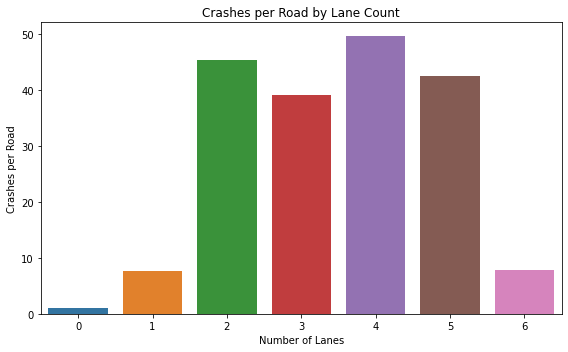

In [186]:
crash_rate = merged_data.groupby('Lanes').agg({
    'TOTAL_CRASHES': 'sum',
    'Street_Name': 'count'
}).rename(columns={'Street_Name': 'Road_Count'}).reset_index()
crash_rate['Crashes_per_Road'] = crash_rate['TOTAL_CRASHES'] / crash_rate['Road_Count']

plt.figure(figsize=(8, 5))
sns.barplot(data=crash_rate, x='Lanes', y='Crashes_per_Road')
plt.title('Crashes per Road by Lane Count')
plt.ylabel('Crashes per Road')
plt.xlabel('Number of Lanes')
plt.tight_layout()
plt.show()

#### Average Severity by Lane Count

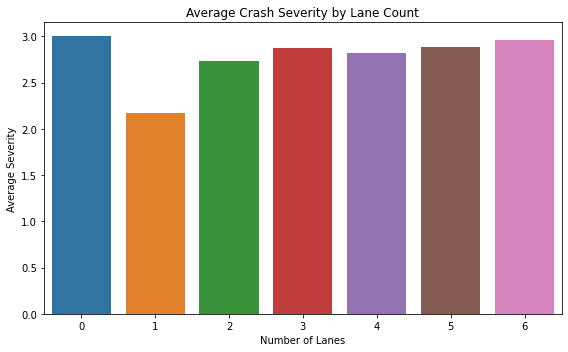

In [187]:
severity_by_lanes = merged_data.groupby('Lanes').agg({
    'AVG_SEVERITY': 'mean'
}).reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=severity_by_lanes, x='Lanes', y='AVG_SEVERITY')
plt.title('Average Crash Severity by Lane Count')
plt.ylabel('Average Severity')
plt.xlabel('Number of Lanes')
plt.tight_layout()
plt.show()

#### Speed vs Severity per Lane Count

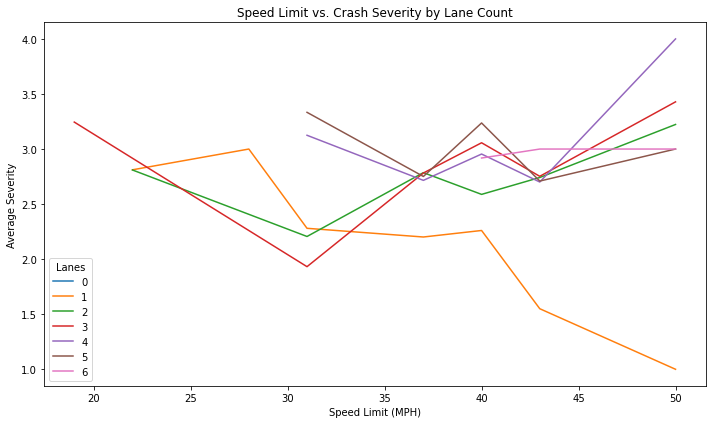

In [188]:
speed_severity_lane = merged_data.groupby(['Lanes', 'Speed_Limit_MPH']).agg({
    'AVG_SEVERITY': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=speed_severity_lane, x='Speed_Limit_MPH', y='AVG_SEVERITY', hue='Lanes', palette='tab10')
plt.title('Speed Limit vs. Crash Severity by Lane Count')
plt.ylabel('Average Severity')
plt.xlabel('Speed Limit (MPH)')
plt.tight_layout()
plt.show()

#### Interaction: Lanes × Road Condition

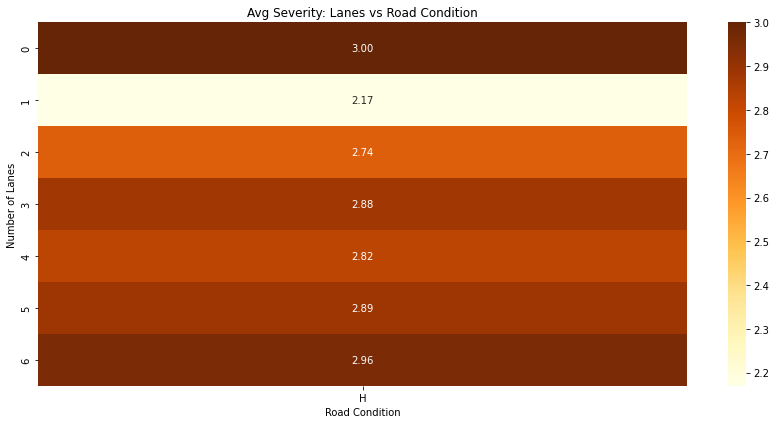

In [189]:
lane_condition = merged_data.groupby(['Lanes', 'COMMON_CONDITION']).agg({
    'AVG_SEVERITY': 'mean',
    'TOTAL_CRASHES': 'sum'
}).reset_index() 

pivot_condition = lane_condition.pivot_table(values='AVG_SEVERITY', index='Lanes', columns='COMMON_CONDITION')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_condition, annot=True, fmt=".2f", cmap='YlOrBr')
plt.title('Avg Severity: Lanes vs Road Condition')
plt.xlabel('Road Condition')
plt.ylabel('Number of Lanes')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
sd_crashes = pd.read_csv('/Users/annaywj/Downloads/SOC_-_Local_Roads__Speed_and_Volume_20250423.csv')
speed_volume = pd.read_csv('/Users/annaywj/Desktop/SDSU/BDA600/Capstone/TIMS_SD_Crashes2013-2024.csv')

In [6]:
relevant_sd_crashes = [
    'ACCIDENT_YEAR', 'COLLISION_DATE', 'COLLISION_TIME', 'DAY_OF_WEEK',
    'PARTY_COUNT', 'COUNT_PED_KILLED', 'COUNT_PED_INJURED',
    'COUNT_MC_KILLED', 'COUNT_MC_INJURED', 'PRIMARY_COLL_FACTOR',
    'COLLISION_SEVERITY', 'LIGHTING', 'ALCOHOL_INVOLVED',
    'CITY', 'LATITUDE', 'LONGITUDE'
]

In [7]:
relevant_speed_volume = [
    'Street Name', 'Lanes', 'Speed Limit MPH', 'Speed 2022 MPH', 'Speed 2021 MPH',
    '1 year Speed % change', '2022 AADT Range', '2021 AADT Range', '1 year AADT % change'
]

In [ ]:
sd_crashes_filtered = sd_crashes[relevant_sd_crashes].copy()
speed_volume_filtered = speed_volume[relevant_speed_volume].copy()


KeyError: "None of [Index(['ACCIDENT_YEAR', 'COLLISION_DATE', 'COLLISION_TIME', 'DAY_OF_WEEK',\n       'PARTY_COUNT', 'COUNT_PED_KILLED', 'COUNT_PED_INJURED',\n       'COUNT_MC_KILLED', 'COUNT_MC_INJURED', 'PRIMARY_COLL_FACTOR',\n       'COLLISION_SEVERITY', 'LIGHTING', 'ALCOHOL_INVOLVED', 'CITY',\n       'LATITUDE', 'LONGITUDE'],\n      dtype='object')] are in the [columns]"

In [ ]:
# First, inspect common columns to determine how they could be merged
common_columns = set(sd_crashes_filtered.columns).intersection(set(speed_volume_filtered.columns))
common_columns
